# MusicVAE

This is my implementation of the MusicVAE described in the paper 
https://arxiv.org/abs/1803.05428 <br>
It is written with the help of the code found here: https://github.com/Variational-Autoencoder/MusicVAE

## Install dependencies

In [ ]:
!pip install pretty_midi

     |████████████████████████████████| 5.6MB 4.6MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-cp36-none-any.whl size=5591954 sha256=9f89163eca0f8ed8e308b0feb18f916289d5c8342effe0eb06164a5e40490bab
  Stored in directory: /root/.cache/pip/wheels/4c/a1/c6/b5697841db1112c6e5866d75a6b6bf1bef73b874782556ba66
Successfully built pretty-midi


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.functional import softplus
#DATA IMPORTING LIBRARIES
# Add the src folder to the path
import sys

sys.path.append('/content/drive/My Drive/MusicVAE/src')
dataset_dir = "/content/drive/My Drive/MusicVAE/Dataset"
model_dir = "/content/drive/My Drive/MusicVAE/Saved_models"
midi_dir = "/content/drive/My Drive/MusicVAE/notebook/midi"

from data.dataloader import MidiDataset
from data.bar_transform import BarTransform
from torch.utils.data import Dataset, DataLoader

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader, random_split


#half of this is not yet needed but maybe it will be to visualize the latent space
import matplotlib.pyplot as plt
from IPython.display import Image, Audio, display, clear_output
import numpy as np
from sklearn.decomposition import PCA
%matplotlib nbagg
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette(sns.dark_palette("purple"))
import pretty_midi as pretty_midi_import

from midi_builder import MidiBuilder
builder = MidiBuilder()

## Set the variables

In [ ]:
from_scratch = True
saving = True


NOTESPERBAR = 16 #total notes in one bar

totalbars = 16 #total bars as input 
NUM_PITCHES = 60+1 # all possible notes to play +1 for silences

TOTAL_NOTES = NOTESPERBAR*totalbars

num_features = NUM_PITCHES #size of input feature vector

batch_size = 64 #actual batchsize

TEACHER_FORCING = True #not used but it will be needed


In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
# Define size of variables

params = dict(
    input_size = NUM_PITCHES, 
    encoder_hidden_size = 256, # hidden size of the encoder 
    conductor_hidden_size = 256, # hidden size of the decoder
    decoder_hidden_size = 64, # hidden size of the decoder
    decoder_initial_size = 32, # input size of the decoder

    n_layers_encoder = 1,
    n_layers_conductor = 2,
    n_layers_decoder = 1,

    latent_features = 64, # latent space dimension
    sequence_length = 16, # notes per decoder

    dropout_rate = 0.2,
    device = device,
    
    csv_filename = dataset_dir + '/piano_rolls.csv',
    
    NOTESPERBAR = NOTESPERBAR,
    totalbars = totalbars, #total bars as input 
    NUM_PITCHES = NUM_PITCHES, # all possible notes to play +1 for silences   
    TOTAL_NOTES = TOTAL_NOTES,
    num_features = num_features, #size of input feature vector
    batch_size = batch_size, #actual batchsize
    TEACHER_FORCING = True #not used but it will be needed
)

## Loading Data

In [ ]:
transform = BarTransform(bars = params['totalbars'], note_count = params['NUM_PITCHES'])
midi_dataset = MidiDataset(csv_file = params['csv_filename'], transform = transform, pretty_midi = pretty_midi_import)
midi_dataset.get_mem_usage()

random_seed = 42
test_split = 0.2
shuffle = True

if random_seed is not None:
    np.random.seed(random_seed)
    
dataset_size = len(midi_dataset)           #number of musics on dataset
test_size = int(test_split * dataset_size) #test size length
train_size = dataset_size - test_size      #train data length

train_dataset, test_dataset = random_split(midi_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, 
                          shuffle=shuffle, 
                          batch_size = params['batch_size'], 
                          num_workers = 4)#, sampler=train_sampler)
test_loader = DataLoader(test_dataset, 
                         shuffle = shuffle, 
                         batch_size = params['batch_size'], 
                         num_workers = 4)#, sampler=test_sampler)

print("Train size: {}, Test size: {}".format(train_size, test_size))

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Train size: 6230, Test size: 1557


In [ ]:
train_dataset[0]['piano_rolls'].shape

(256, 61)

## MusicVAE Model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, params):
        super(Encoder, self).__init__()
        self.latent_features = params['latent_features']
        self.decoder_initial_size = params['decoder_initial_size']
        self.encoder_hidden_size = params['encoder_hidden_size']
        self.NUM_PITCHES = params['NUM_PITCHES']
        self.device = params['device']
        self.dropout_rate = params['dropout_rate']
        self.worddropout = nn.Dropout2d(p = self.dropout_rate)
        
        self.encoder = nn.LSTM(
            input_size = params['input_size'],
            hidden_size = params['encoder_hidden_size'],
            num_layers = params['n_layers_encoder'],
            batch_first = True,
            bidirectional = True)
        self.encoderOut = nn.Linear(2 * self.encoder_hidden_size, 2 * self.latent_features)
        self.linear_z = nn.Linear(self.latent_features, self.decoder_initial_size) 
        
    def init_hidden(self, batch_size):   
        init = torch.zeros(2, batch_size, self.encoder_hidden_size, device = self.device)
        c0 = torch.zeros(2, batch_size, self.encoder_hidden_size, device = self.device)
        return init, c0

    def epsilon(self, epsilon_size):
        # Don't propagate gradients through randomness
        with torch.no_grad():
            epsilon = torch.randn(epsilon_size, 1, self.latent_features, device = self.device)
        return epsilon
        
    def forward(self, x):
        batch_size = x.size(0)
        note = torch.zeros(batch_size, 1 , self.NUM_PITCHES, device = self.device)
        x = self.worddropout(x)
        h0, c0, = self.init_hidden(batch_size)
        x, hidden = self.encoder(x, (h0,c0))
        x = self.encoderOut(x)
        mu, log_var = torch.chunk(x, 2, dim = -1)
        log_var = softplus(log_var) # Make sure that the log variance is positive

        sigma = torch.exp(2 * log_var)
        epsilon = self.epsilon(mu.size(0))
        z = mu + epsilon * sigma
        z = self.linear_z(z)
        return z, mu, log_var
        

In [ ]:
class Decoder(nn.Module):
    def __init__(self, params, eps_i = 1):
        super(Decoder, self).__init__()
        self.latent_features = params['latent_features']
        self.decoder_initial_size = params['decoder_initial_size']
        self.encoder_hidden_size = params['encoder_hidden_size']
        self.NUM_PITCHES = params['NUM_PITCHES']
        self.TOTAL_NOTES = params['TOTAL_NOTES']
        self.device = params['device']
        self.TEACHER_FORCING = params['TEACHER_FORCING']
        self.totalbars = params['totalbars']
        self.eps_i = eps_i
        self.sequence_length = params['sequence_length']
        
        self.conductor = nn.LSTM(
            input_size = self.decoder_initial_size, 
            hidden_size = self.decoder_initial_size, 
            num_layers = 1,
            batch_first = True
        )
        
        self.decoder = nn.LSTM(
            input_size = self.NUM_PITCHES + self.decoder_initial_size,
            hidden_size = self.decoder_initial_size, 
            num_layers = 1,
            batch_first = True)
        
        self.linear = nn.Linear(self.decoder_initial_size, self.NUM_PITCHES)
    
    def set_scheduled_sampling(self, eps_i):
        self.eps_i = eps_i
    
    def use_teacher_forcing(self):
        with torch.no_grad():
            tf = np.random.rand(1)[0] <= self.eps_i
        return tf   
    
    def init_hidden(self, batch_size):
        init_conductor = torch.zeros(1, batch_size, self.decoder_initial_size, device = self.device)
        c_condunctor = torch.zeros(1, batch_size, self.decoder_initial_size, device = self.device)     
        return init_conductor, c_condunctor
    
    def forward(self, z, x, generation = False):
        ''' If we want to generate a random sample from the latent space, the variable x
            is just the batch dimension, otherwise is the real input (a song)'''
        if generation:
            batch_size = x
        else: 
            batch_size = x.size(0)
        
        hconductor, cconductor = self.init_hidden(batch_size)
        conductor_hidden = (hconductor,cconductor)
        notes = torch.zeros(batch_size, self.TOTAL_NOTES, self.NUM_PITCHES, device = self.device)
        counter = 0
        
        note = torch.zeros(batch_size, 1 , self.NUM_PITCHES, device = self.device)
        if self.use_teacher_forcing() and (not generation):
          the_input = torch.cat([note,x],dim=1)
        for i in range(self.totalbars):
            embedding, conductor_hidden = self.conductor(z[:,i,:].view(batch_size, 1, -1), conductor_hidden)  
            # Reset the decoder state of each 16 bar sequence
            decoder_hidden = (torch.randn(1, batch_size, self.decoder_initial_size, device = self.device), 
                              torch.randn(1, batch_size, self.decoder_initial_size, device = self.device))
            if self.use_teacher_forcing() and (not generation):
                embedding = embedding.expand(batch_size, NOTESPERBAR, embedding.shape[2])
                e = torch.cat([embedding,the_input[:, range(i * 16, i * 16 + 16),:]],dim = -1)
                notes2, decoder_hidden = self.decoder(e, decoder_hidden)
                aux = self.linear(notes2)
                aux = torch.softmax(aux, dim = 2);
                #generates 16 notes per batch at a time
                notes[:, range(i * 16, i * 16 + 16),:] = aux;
            else:           
                for _ in range(self.sequence_length):
                    # Concat embedding with previous note         
                    e = torch.cat([embedding, note], dim = -1)
                    e = e.view(batch_size, 1, -1)
                    # Generate a single note (for each batch)
                    note, decoder_hidden = self.decoder(e, decoder_hidden)                  
                    aux = self.linear(note)
                    aux = torch.softmax(aux, dim = 2);                   
                    notes[:,counter,:] = aux.squeeze();                   
                    note = aux                    
                    counter = counter + 1
        outputs = {}         
        outputs['x_hat'] = notes
        outputs['z'] = z
        return outputs 
       

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, params):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(params)
        self.decoder = Decoder(params)
        self.device = params['device']
        self.NUM_PITCHES = params['NUM_PITCHES']
        self.TOTAL_NOTES = params['TOTAL_NOTES']
        self.decoder_initial_size = params['decoder_initial_size']
        
    def set_scheduled_sampling(self, eps_i):
        self.decoder.set_scheduled_sampling(eps_i)

    def generate_sample(self, gen_batch):
        z_gen = torch.randn(gen_batch, 256, 32, device = self.device)
        sample = self.decoder(z_gen, gen_batch, generation = True)
        return sample
         
    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        outputs = self.decoder(z,x)
        outputs['mu'] = mu
        outputs['log_var'] = log_var
        return outputs    
    

## Creation Model

In [ ]:
MusicVAE = VariationalAutoencoder(params)
MusicVAE.to(device)

VariationalAutoencoder(
  (encoder): Encoder(
    (worddropout): Dropout2d(p=0.2, inplace=False)
    (encoder): LSTM(61, 256, batch_first=True, bidirectional=True)
    (encoderOut): Linear(in_features=512, out_features=128, bias=True)
    (linear_z): Linear(in_features=64, out_features=32, bias=True)
  )
  (decoder): Decoder(
    (conductor): LSTM(32, 32, batch_first=True)
    (decoder): LSTM(93, 32, batch_first=True)
    (linear): Linear(in_features=32, out_features=61, bias=True)
  )
)

## Loss Function (ELBO)

In [ ]:
#directly taken from notebook, probably some adaptation might be needed

from torch.nn.functional import binary_cross_entropy
from torch import optim
from torch.distributions.normal import Normal
from torch.distributions.kl import kl_divergence


def ELBO_loss(y, t, mu, log_var, weight):
    # Reconstruction error, log[p(x|z)]
    # Sum over features
    likelihood = -binary_cross_entropy(y, t, reduction="none")
    likelihood = likelihood.view(likelihood.size(0), -1).sum(1)

    # Regularization error: 
    # Kulback-Leibler divergence between approximate posterior, q(z|x)
    # and prior p(z) = N(z | mu, sigma*I).
    sigma = torch.exp(log_var*2)
    n_mu = torch.Tensor([0])
    n_sigma = torch.Tensor([1])
    if cuda:
        n_mu = n_mu.cuda()
        n_sigma = n_sigma.cuda()

    p = Normal(n_mu, n_sigma)
    q = Normal(mu, sigma)

    #The method signature is P and Q, but might need to be reversed to calculate divergence of Q with respect to P
    kl_div = kl_divergence(q, p)
    
    # In the case of the KL-divergence between diagonal covariance Gaussian and 
    # a standard Gaussian, an analytic solution exists. Using this excerts a lower
    # variance estimator of KL(q||p)
    #kl = -weight * torch.sum(1 + log_var - mu**2 - torch.exp(log_var), dim=(1,2))
    
    # Combining the two terms in the evidence lower bound objective (ELBO) 
    # mean over batch
    ELBO = torch.mean(likelihood) - (weight*torch.mean(kl_div)) # add a weight to the kl using warmup
    
    # notice minus sign as we want to maximise ELBO
    return -ELBO, kl_div.mean(),weight*kl_div.mean() # mean instead of sum



# define our optimizer
# The Adam optimizer works really well with VAEs.
#params = list(encoder.parameters()) + list(decoder.parameters())
params_weights = MusicVAE.parameters()
optimizer = optim.Adam(params_weights, lr=0.001)
loss_function = ELBO_loss

## SOME TESTS

Testing if forward pass works

In [ ]:
from torch.autograd import Variable

#setting dummy data
#Generating dummy data
a = np.random.randint(NUM_PITCHES, size = TOTAL_NOTES)
data = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data

a = np.random.randint(NUM_PITCHES, size = TOTAL_NOTES)
data1 = np.zeros((TOTAL_NOTES, NUM_PITCHES))
data1[np.arange(TOTAL_NOTES), a] = 1 #generating dummy data
d = np.zeros((2,TOTAL_NOTES, NUM_PITCHES))
d[0] = data
d[1] = data1

print(d.shape)
x = d 
x = Variable(torch.Tensor(x)).to(device)
#z, mu, log_var = encoder(x)
#outputs = decoder(z,x)
outputs = MusicVAE(x)


x_hat = outputs["x_hat"]
z = outputs["z"]
mu = outputs['mu']
log_var = outputs['log_var']

loss, kl,klw = loss_function(x_hat, x, mu, log_var,1)

print('x shape:', x.shape)
print('h_hat shape', x_hat.shape)
print('z shape:', z.shape)
print(loss)
print(kl)


(2, 256, 61)
x shape: torch.Size([2, 256, 61])
h_hat shape torch.Size([2, 256, 61])
z shape: torch.Size([2, 256, 32])
tensor(1828.7150, device='cuda:0', grad_fn=<NegBackward>)
tensor(1.1544, device='cuda:0', grad_fn=<MeanBackward0>)


Testing if sample step works

In [ ]:
sample = MusicVAE.generate_sample(10)

## Training

In [ ]:
num_epochs = 100
warmup_epochs= 90
pre_warmup_epochs = 10
scheduled_decay_rate = 40

warmup_lerp = 1/warmup_epochs

In [ ]:
# from torch.autograd import Variable
import time
import os
import math

warmup_w=0

eps_i = 1
use_scheduled_sampling = False
if from_scratch:
  train_loss, valid_loss = [], []
  train_kl, valid_kl,train_klw = [], [],[]
else:
  MusicVAE = torch.load(model_dir + '/ModelVAE.pt')
  train_loss = torch.load(model_dir + '/train_loss.pt')
  valid_loss = torch.load(model_dir + '/valid_loss.pt')
  train_kl = torch.load(model_dir + '/train_kl.pt')
  valid_kl = torch.load(model_dir + '/valid_kl.pt')
  train_klw = torch.load(model_dir + '/train_klw.pt')


In [ ]:
train_loss

[]

In [ ]:
start = time.time()
tmp_img = "tmp_vae_out.png"

print("Training epoch {}".format(0))
#epochs loop
for epoch in range(num_epochs):
    
    batch_loss, batch_kl, batch_klw = [], [], []
    MusicVAE.train()

    for i_batch, sample_batched in enumerate(train_loader):
        #if i_batch == 10:
        #    break
        x = sample_batched['piano_rolls']

        x = x.type('torch.FloatTensor')
        
        #if i_batch%10==0:
        #    print("batch:",i_batch)

        x = Variable(x)

        # This is an alternative way of putting
        # a tensor on the GPU
        x = x.to(device)
        
        ## Calc the sched sampling rate:
        if epoch >= pre_warmup_epochs and use_scheduled_sampling:
            eps_i = inv_sigmoid_decay(i_batch, rate=scheduled_decay_rate)

        MusicVAE.set_scheduled_sampling(eps_i)
        
        outputs = MusicVAE(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']

        elbo, kl,kl_w = loss_function(x_hat, x, mu, log_var, warmup_w)

        optimizer.zero_grad()
        elbo.backward()
        optimizer.step()

        batch_loss.append(elbo.item())
        batch_kl.append(kl.item())
        batch_klw.append(kl_w.item())
    train_loss.append(np.mean(batch_loss))
    train_kl.append(np.mean(batch_kl))
    train_klw.append(np.mean(batch_klw))
    print('Epoch:', epoch)

    # Evaluate, do not propagate gradients
    with torch.no_grad():
        MusicVAE.eval()

        # Just load a single batch from the test loader
        x = next(iter(test_loader))
        x = Variable(x['piano_rolls'].type('torch.FloatTensor'))

        x = x.to(device)

        MusicVAE.set_scheduled_sampling(1.) # Please use teacher forcing for validations
        outputs = MusicVAE(x)
        x_hat = outputs['x_hat']
        mu, log_var = outputs['mu'], outputs['log_var']
        z = outputs["z"]

        elbo, kl,klw = loss_function(x_hat, x, mu, log_var, warmup_w)

        # We save the latent variable and reconstruction for later use
        # we will need them on the CPU to plot
        x = x.to("cpu")
        x_hat = x_hat.to("cpu")
        z = z.detach().to("cpu").numpy()

        valid_loss.append(elbo.item())
        valid_kl.append(kl.item())
    
    if epoch >= pre_warmup_epochs:
        warmup_w = warmup_w + warmup_lerp
        if warmup_w > 1:
            warmup_w=1.
    
    if epoch == 0:
        continue
            
    # -- Plotting --
    f, axarr = plt.subplots(2, 1, figsize=(10, 10))
    
    
    # Loss
    ax = axarr[0]
    ax.set_title("ELBO")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Error')

    ax.plot(np.arange(len(train_loss)), train_loss, color="black")
    ax.plot(np.arange(len(valid_loss)), valid_loss, color="gray", linestyle="--")
    ax.legend(['Training', 'Validation'])
    
    
    # KL / reconstruction
    ax = axarr[1]
    
    ax.set_title("Kullback-Leibler Divergence")
    ax.set_xlabel('Epoch')
    ax.set_ylabel('KL divergence')


    ax.plot(np.arange(len(train_kl)), train_kl, color="black")
    ax.plot(np.arange(len(valid_kl)), valid_kl, color="gray", linestyle="--")
    ax.plot(np.arange(len(train_klw)), train_klw, color="blue", linestyle="--")
    ax.legend(['Training', 'Validation','Weighted'])
    
    print("Epoch: {}, {} seconds elapsed".format(epoch, time.time() - start))
    
    plt.savefig(tmp_img)
    plt.close(f)
    display(Image(filename=tmp_img))
    
    clear_output(wait=True)

    os.remove(tmp_img)

end_time = time.time() - start
print("Finished. Time elapsed: {:4f} seconds".format(end_time))

Training epoch 0


KeyboardInterrupt: ignored

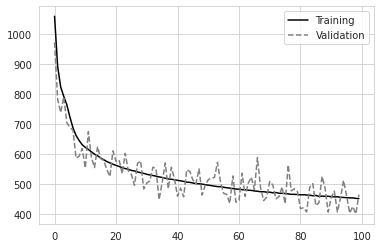

In [ ]:
# We plot the loss
plt.plot(train_loss, color = 'black')
plt.plot(valid_loss, color="gray", linestyle="--")
plt.legend(['Training', 'Validation'])

Save the data 

In [ ]:
if saving:
  torch.save(MusicVAE, model_dir + '/ModelVAE.pt')
  torch.save(train_loss, model_dir + '/train_loss.pt')
  torch.save(valid_loss, model_dir + '/valid_loss.pt')
  torch.save(train_kl, model_dir + '/train_kl.pt')
  torch.save(valid_kl, model_dir + '/valid_kl.pt')
  torch.save(train_klw, model_dir + '/train_klw.pt')

## Generation some sample

Testing Sample in the neighbors of a given real song

In [ ]:
if not (from_scratch):
  MusicVAE = torch.load(model_dir + '/ModelVAE.pt')

In [ ]:
notes_np = np.array([train_dataset[0]['piano_rolls'], train_dataset[1]['piano_rolls'], train_dataset[2]['piano_rolls']])
notes_np.shape

(3, 256, 61)

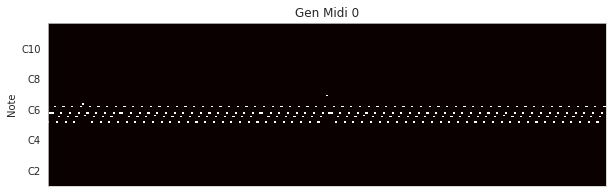

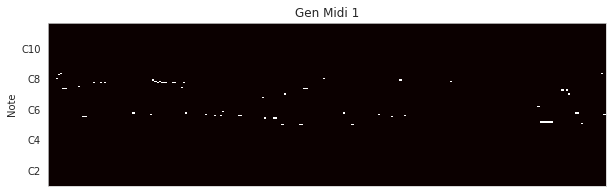

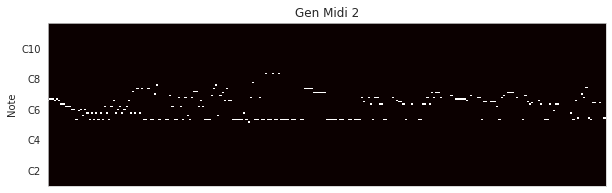

In [ ]:
for i, seq in enumerate(notes_np):
    row_maxes = seq.max(axis = 1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:, -1]):
        print("Midi: {} is all silent".format(i))
        continue
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Gen Midi {}".format(i))
    
    builder.plot_midi(midi)
    midi.write(midi_dir + '/original_{}.mid'.format(i))

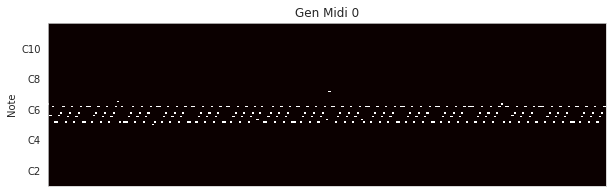

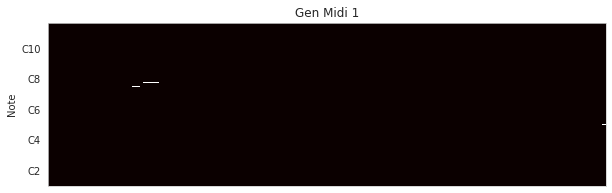

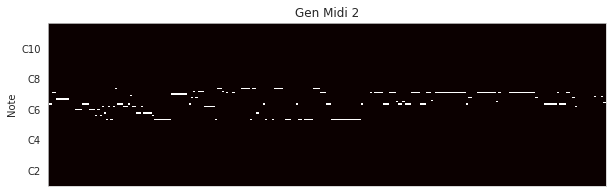

In [ ]:
x = torch.tensor(notes_np).to(device)
x = x.type(torch.float32)
outputs = MusicVAE(x)
notes = outputs['x_hat'].cpu().detach().numpy()
for i, seq in enumerate(notes):
    row_maxes = seq.max(axis = 1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:, -1]):
        print("Midi: {} is all silent".format(i))
        continue
    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Gen Midi {}".format(i))
    
    builder.plot_midi(midi)
    midi.write(midi_dir + '/reconstruct_{}.mid'.format(i))

In [ ]:
samples = MusicVAE.generate_sample(10)
notes_gen = samples['x_hat']

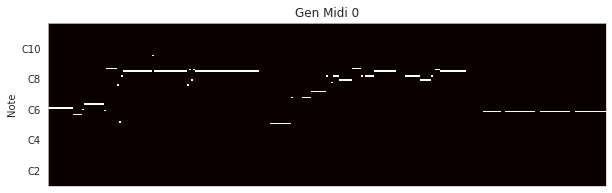

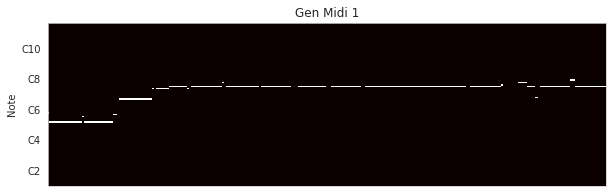

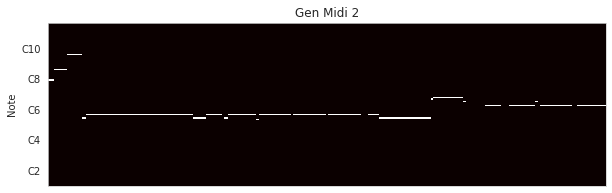

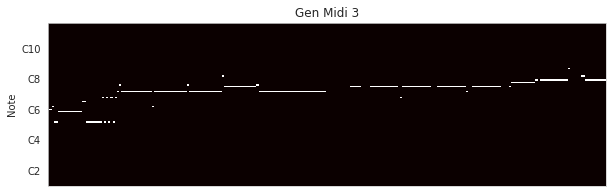

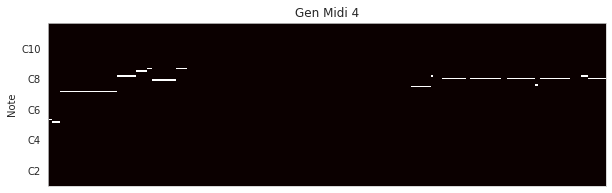

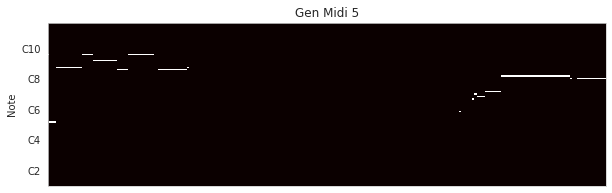

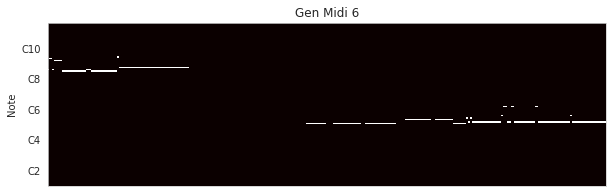

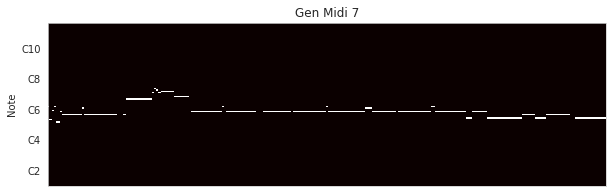

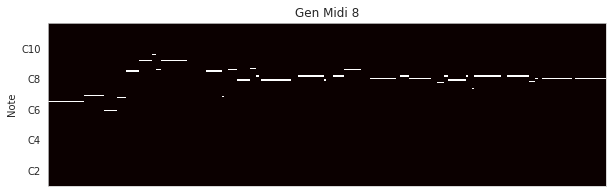

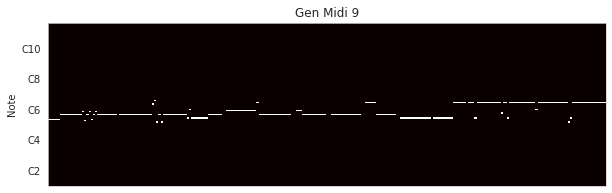

In [ ]:
notes_np = notes_gen.cpu().detach().numpy()
notes_np.shape
for i, seq in enumerate(notes_np):
    row_maxes = seq.max(axis = 1).reshape(-1, 1)
    midi_out = np.where(seq == row_maxes, 1, 0)
    if np.all(midi_out[:, -1]):
        print("Midi: {} is all silent".format(i))
        continue

    np.savetxt(midi_dir + "/gen_csv_midi_out_{}.csv".format(i), midi_out, delimiter=";")

    midi = builder.midi_from_piano_roll(midi_out[:,:-1]) # Select all notes but the silent one
    plt.figure(figsize=(10, 3))
    plt.title("Gen Midi {}".format(i))
    
    builder.plot_midi(midi)
    plt.savefig(midi_dir + "/gen_img_midi_{}.png".format(i))

    midi.write(midi_dir + '/gen_{}.mid'.format(i))

## DRAFTS

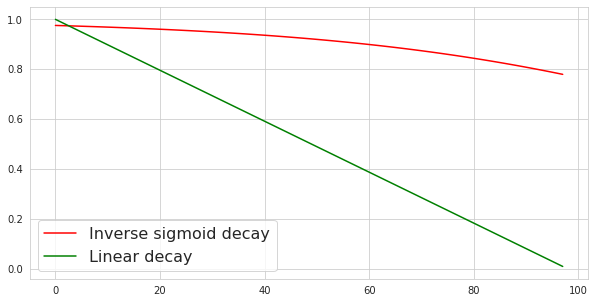

In [ ]:
def lin_decay(i, mineps=0):
    return np.max([mineps, 1 - (1/len(train_loader))*i])

def inv_sigmoid_decay(i, rate=40):
    return rate/(rate + np.exp(i/rate))

eps = []
for i in range(len(train_loader)):
    eps_i = inv_sigmoid_decay(i, rate=scheduled_decay_rate)
    eps.append(eps_i)

    
eps2 = []
for i in range(len(train_loader)):
    eps_i = lin_decay(i, 0)
    eps2.append(eps_i)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(eps, color="red")
ax.plot(eps2, color="green")
ax.legend(['Inverse sigmoid decay', 'Linear decay'], prop={'size': 16})

Estimated time until completion: 0.67 hours / 40.00 minutes/ 2400.00 seconds


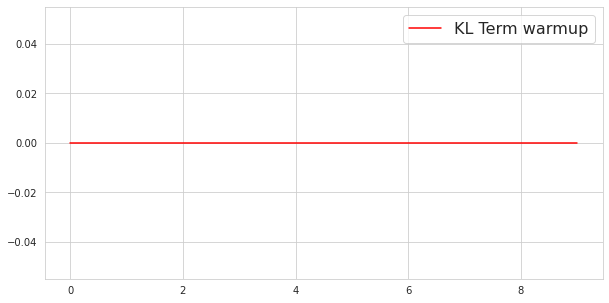

In [ ]:
# 3 = ~12 minutes
#num_epochs = 200
#warmup_epochs= 90
#pre_warmup_epochs = 10


warmup_lerp = 1/warmup_epochs

if warmup_epochs > num_epochs - pre_warmup_epochs:
    warmup_epochs=num_epochs - pre_warmup_epochs


# Plot how the warmup looks
kl_w = 0
kls = []
for e in range(num_epochs):
    if e >= pre_warmup_epochs:
        kl_w = kl_w + warmup_lerp
        if kl_w > 1:
            kl_w=1.

    kls.append(kl_w)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(kls, color="red")
ax.legend(['KL Term warmup'], prop={'size': 16})

est_time = 4*num_epochs
print("Estimated time until completion: {:.2f} hours / {:.2f} minutes/ {:.2f} seconds".format(est_time/60, est_time, est_time*60))

In [ ]:
encoder = Encoder(params).to(device)
decoder = Decoder(params).to(device)

In [ ]:
MusicVAE = VariationalAutoencoder(params)